# Analisi statistica intervalli di ricorrenza extreme returns

Questo notebook contiene le analisi statistiche fatte per il paper.

Il flusso è il seguente:

- [x] utilizzo del dataset *Dow Jones* con la massima ampiezza storica disponibile (1985 - 2019)
- [x] calcolo dei log returns
- [x] plot degli intervalli di ricorrenza per il Dow Jones, con metodi diversi:
    - [x] quantile threshold al
        - [x] 95%
        - [x] 97.5%
        - [x] 99%
        - [x] verifica della relazione $\tau_Q = \frac{Q}{1 - Q}$ dove $Q$ è il quantile scelto (0.95, 0.975, 0.99), $\tau_Q$ l'intervallo di ricorrenza medio, e confronto con l'evidenza dei dati
    - [x] peak-over-threshold definito come $pot = \mu \pm m \cdot \sigma$: ricavare analiticamente m come $m = \frac{q_x - \mu}{\sigma}$ dove $q_x$ è il quantile di ordine $x$
        
Infine, tutto dovrà essere rifatto per una azione dell'*S&P500*, non per il Dow Jones come di seguito.

In [1]:
import os
import time
import datetime
from typing import List
import itertools
import pickle
import math

import numpy as np
import pandas as pd
import scipy.stats
import scipy.special as sfun
from scipy.stats import genextreme as gev

from statsmodels.tsa import stattools
from statsmodels.graphics import tsaplots

import matplotlib.pyplot as pl
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from tqdm import tqdm
import pdb

import numba

# import stimatore di Hill
import tail_estimation
from my_timeit import timeit

In [2]:
%pdb on

Automatic pdb calling has been turned ON


In [3]:
%load_ext line_profiler
%load_ext autoreload
%load_ext cython

In [4]:
%autoreload 5

In [35]:
return_type = ['pos', 'neg', 'abs']
quantile_type = ['95', '97.5', '99', 'evt']

colors = {
    'pos': 'seagreen',
    'neg': 'darkred',
    'abs': 'royalblue',
}

legend_labels = {
    'pos': r'$r$',
    'neg': r'$-r$',
    'abs': r'$|r|$',
}

## 1. Caricamento dei dati e divisione train-test

In [6]:
data_path = "/Users/pietro/Google Drive/OptiRisk Thesis/data"
djia_path = os.path.join(data_path, 'DJIA.csv')

Conversione delle date e settaggio dell'index del dataframe

In [7]:
djia = pd.read_csv(djia_path)
djia.loc[:, 'Date'] = pd.to_datetime(djia['Date'], format="%Y-%m-%d")
djia.index = djia['Date']
djia.drop(columns=['Date'], inplace=True)
djia.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000
1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000
1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000
1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000
1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000


Ora dichiariamo le date in cui bisogna dividere i dati, visto che ci sono state crisi nei mesi/anni successivi:

In [38]:
split_dates = {
    'insurance': datetime.datetime(1987, 1, 1), # insurance companies crisis
    'dot-com': datetime.datetime(2000, 1, 1), # dot-com bubble explodes
    'subprime-crisis': datetime.datetime(2007, 1, 1), # subprime crisis
    'eu-debt': datetime.datetime(2011, 1, 1), # EU sovereign debt crisis
}

## 2. Calcolo log-returns

In [39]:
log_returns = np.log(djia.loc[:, ['Adj Close']]).diff(periods=1).iloc[1:, :]
log_returns.head()

,Adj Close
Date,
1985-01-30,-0.003674
1985-01-31,-0.000862
1985-02-01,-0.007058
1985-02-04,0.009627
1985-02-05,-0.003767


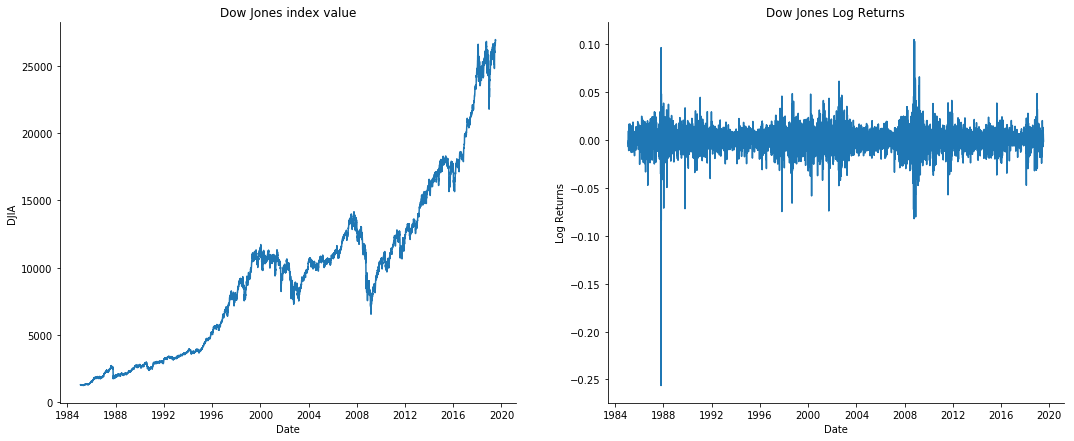

In [40]:
fig, ax = pl.subplots(nrows=1, ncols=2, figsize=(18, 7))

ax[0].plot(djia['Adj Close'])
ax[0].set(xlabel='Date', ylabel='DJIA', title='Dow Jones index value')
sns.despine()

ax[1].plot(log_returns, label='Log Returns')
ax[1].set(xlabel='Date', ylabel='Log Returns', title='Dow Jones Log Returns')
sns.despine()

Creo una funzione per dividere il dataset prima e dopo gli eventi critici:

In [41]:
def divide(data: pd.DataFrame, before_date: datetime.datetime):
    """Split the data before and after the before_date."""
    before = data[data.index < before_date]
    after = data[data.index >= before_date]
    
    return before, after

In [42]:
returns_before_after = {
    event: divide(log_returns, split_dates[event])
    for event in split_dates.keys()
}

Ora scelgo quale sia la data di splitting e faccio le analisi con quella:

In [43]:
split_key = 'subprime-crisis'

## 3. Stima dei parametri della distribuzione GEV

In questa sezione si replica la sezione 4.1 del paper.

Secondo la [Extreme Value Theory](https://en.wikipedia.org/wiki/Extreme_value_theory), trovare gli estremi significa trovare un gruppo di dati $x \geq x_t$ dove $x_t$ è l'*extreme value threshold*, e che soddisfi la GEV ([Generalized Extreme Values Distribution](https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution)) che ha distribuzione cumulativa:

\begin{align*}
    G(x) &= exp\left[- \left(1 + \xi \frac{x - \mu}{\sigma}\right)^{-1/\xi}\right] \; for \; \xi \neq 0\\ 
    G(x) &= exp\left[-exp\left(\frac{x - \mu}{\sigma}\right)\right] \; for \; \xi = 0\\ 
\end{align*}

dove $\xi$ è lo *shape parameter* che determina la forma della coda, $1/\xi$ è il *tail exponent* della distribuzione.

Per trovare il threshold $x_t$, usiamo questo metodo:

1. sort dei dati (tutti i log-returns) in ordine discendente (o non-ascendente) per avere la sequenza $x_1 \geq x_2 \geq \ldots \geq x_n$
2. applicare lo [stimatore di Hill](https://en.wikipedia.org/wiki/Heavy-tailed_distribution#Hill's_tail-index_estimator) dove $n$ è il numero di samples, $k$ l'indice del k-esimo dato più grande (posizione k nella sequenza ordinata) chiamato *k-th order statistic*

$$\hat{\xi}_{k,n} = \frac{1}{\gamma - 1} = \frac{1}{k}\sum_{i=1}^{k}log\left(\frac{x_i}{x_{k+1}}\right)$$

3. calcolare la statistica di [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Kolmogorov%E2%80%93Smirnov_statistic) per quantificare il fitting tra la distribuzione GEV così ricavata (con $\hat{\xi}_{k,n}$ come esponente) e quella empirica della coda, dove la coda è rappresentata dai returns che sono $x \geq x_t$, cioé quelli ordinati discendenti con indice $i < k$
4. scegliere $k$ (e di conseguenza $x_t$ che non è altro che il k-esimo elemento dei return ordinati discendenti) come il valore associato alla *minima* statistica di Kolmogorov-Smirnov

Questo flusso viene applicato a tutti e 3 i tipi di returns considerati: positivi, negativi e assoluti.

Cominciamo:

### 3.1 Stima di $\gamma$

In [25]:
@timeit
def estimate_shape_param(x: np.ndarray, get_optimum=False, n_times=1):
    """Estimate the shape parameter gamma for the GEV using Hill estimator.
    Input MUST be sorted in descending order.
    """
    # xi_estimation[0]: order statistics
    # xi_estimation[1]: tail index estimates (xi su Wikipedia, gamma nel paper)
    # xi_estimation[2]: optimal order statistics (k)
    # xi_estimation[3]: tail index for the optimal order statistics

    # xi_estimation[4]: array of fractions of order statistics used for the 1st bootstrap sample
    # xi_estimation[5]: corresponding AMSE values
    # xi_estimation[6]: fraction of order statistics corresponding to the minimum of AMSE for the 1st bootstrap
    # xi_estimation[7]: index of the 1st bootstrap sample's order statistics array corresponding to the
    #                   minimization boundary set by eps_stop parameter

    # xi_estimation[8]: array of fractions of order statistics used for the 2nd bootstrap sample
    # xi_estimation[9]: corresponding AMSE values
    # xi_estimation[10]: fraction of order statistics corresponding to the minimum of AMSE for the 2nd bootstrap
    # xi_estimation[11]: index of the 2nd bootstrap sample's order statistics array corresponding to the
    #                   minimization boundary set by eps_stop parameter
    assert isinstance(get_optimum, bool)
    
    # check descending
    assert np.all(np.diff(x) <= 0.0)
    
    xis = np.zeros((n_times, x.shape[0] - 1))
    optimal_kappas = np.zeros((n_times, ), dtype=np.int)
    optimal_xis = np.zeros((n_times, ), dtype=np.float64)
    
    for i in range(n_times):
        xi_estimation = tail_estimation.hill_estimator(x, bootstrap=get_optimum)

        kappas = xi_estimation[0]
        xi_hill = xi_estimation[1]
        
        xis[i, :] = xi_hill[:]
        
        if get_optimum:
            optimal_kappas[i] = xi_estimation[2]
            optimal_xis[i] = xi_estimation[3]
            
    xis = np.mean(xis, axis=0)  # per ogni colonna (k) la media delle xi che ha trovato
    
    if get_optimum:
        optimal_k = int(round(np.mean(optimal_kappas)))
        optimal_xi = np.mean(optimal_xis)
        optimal_gamma = 1.0 + (1.0 / optimal_xi)
        
        return {
            'kappas': kappas,
            'xis': xis,
            'gammas': 1.0 + (1.0 / xis),
            'k_opt': optimal_k,
            'xi_opt': optimal_xi,
            'gamma_opt': optimal_gamma,
        }
    else:
        return {
            'kappas': kappas,
            'xis': xis,
            'gammas': 1.0 + (1.0 / xis),
        }

Calcolo i return ordinati dal più grande al più piccolo per i positivi, negativi e assoluti:

In [44]:
# 0. scelta di dove fermarsi, qui prima della crisi finanziaria 2007-2008
lr_before, lr_after = returns_before_after[split_key]

# 1. sorting dei returns - va fatto sia per il positivo, che per il negativo, che per gli assoluti
returns = {
    'pos': lr_before['Adj Close'][lr_before['Adj Close'] > 0.0],
    'neg': lr_before['Adj Close'][lr_before['Adj Close'] < 0.0],
    'abs': lr_before['Adj Close'].abs(),
}

sorted_positive_lr = returns['pos'].sort_values(ascending=False)
sorted_negative_lr = (-returns['neg']).sort_values(ascending=False)
sorted_absolute_lr = returns['abs'].sort_values(ascending=False)

eps = 5e-6

sorted_lr = {
    'pos': sorted_positive_lr[sorted_positive_lr >= eps],
    'neg': sorted_negative_lr[sorted_negative_lr >= eps],
    'abs': sorted_absolute_lr[sorted_absolute_lr >= eps],
}

Calcolo la stima di $\xi = \frac{1}{\gamma - 1}$ con lo stimatore di Hill per i tre returns:

In [45]:
hill_estimation = {
    ret_type: estimate_shape_param(sorted_lr[ret_type].values, get_optimum=True, n_times=30)
    for ret_type in return_type
}

print("")
title_format = "{:>15}"*4
row_format = "{:>15}" + "{:>15.3f}" * 2 + "{:>15}"
print(title_format.format('Return type', 'Xi', 'gamma = -c', 'k'))
print("-"*60)
for ret_type in return_type:
    est = hill_estimation[ret_type]
    print(row_format.format(ret_type, est['xi_opt'], est['gamma_opt'], est['k_opt']))

Elapsed time is   9.21s
Elapsed time is   8.11s
Elapsed time is  14.58s

    Return type             Xi     gamma = -c              k
------------------------------------------------------------
            pos          0.308          4.246            116
            neg          0.361          3.774            214
            abs          0.312          4.204            309


### 3.2 Plot di $\xi_{k, n}$ e $\gamma$ al variare di k e dei returns

Plot di $\xi$ e $\gamma$ al variare di $k$, cioè del threshold, e plot di $\xi$ e $\gamma$ al variare dei return, per vedere come cambia a seconda di quale return si prenda come threshold:

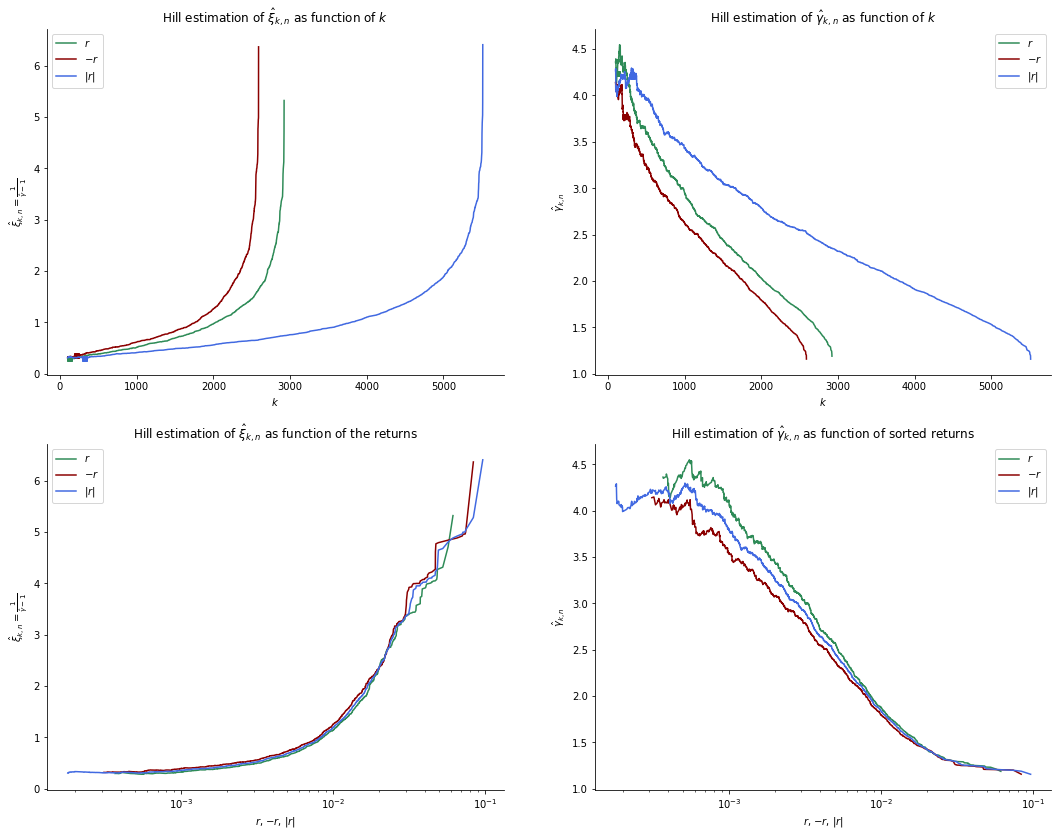

In [46]:
# plot delle stime di xi e gamma al variare di k
truncation = 100

fig, ax = pl.subplots(nrows=2, ncols=2, figsize=(18, 14))

# Xi
for ret_type in return_type:
    est = hill_estimation[ret_type]
    x = est['kappas'][truncation:]
    y = est['xis'][truncation:]

    ax[0][0].plot(x, y, color=colors[ret_type], label=legend_labels[ret_type])
    ax[0][0].plot(est['k_opt'], est['xi_opt'], marker='s', markersize=5, color=colors[ret_type])

ax[0][0].set(
    xlabel=r'$k$',
    ylabel=r'$\hat{\xi}_{k,n} = \frac{1}{\hat{\gamma} - 1}$',
    title=r'Hill estimation of $\hat{\xi}_{k,n}$ as function of $k$'
)
ax[0][0].legend()


# gamma
for ret_type in return_type:
    est = hill_estimation[ret_type]
    x = est['kappas'][truncation:]
    y = est['gammas'][truncation:]

    ax[0][1].plot(x, y, color=colors[ret_type], label=legend_labels[ret_type])
    ax[0][1].plot(est['k_opt'], est['gamma_opt'], marker='s', markersize=5, color=colors[ret_type])

ax[0][1].set(
    xlabel=r'$k$',
    ylabel=r'$\hat{\gamma}_{k,n}$',
    title=r'Hill estimation of $\hat{\gamma}_{k,n}$ as function of $k$'
)
ax[0][1].legend()


# seconda riga, in funzione dei log-returns
# Xi
for ret_type in return_type:
    est = hill_estimation[ret_type]
    x = sorted_lr[ret_type].values[1:][::-1][truncation:]
    y = est['xis'][truncation:]

    ax[1][0].semilogx(x, y, color=colors[ret_type], label=legend_labels[ret_type])

ax[1][0].set(
    xlabel=r'$r$, $-r$, $|r|$',
    ylabel=r'$\hat{\xi}_{k,n} = \frac{1}{\hat{\gamma} - 1}$',
    title=r'Hill estimation of $\hat{\xi}_{k,n}$ as function of the returns'
)
ax[1][0].legend()

# gamma
for ret_type in return_type:
    est = hill_estimation[ret_type]
    x = sorted_lr[ret_type].values[1:][::-1][truncation:]
    y = est['gammas'][truncation:]

    ax[1][1].semilogx(x, y, color=colors[ret_type], label=legend_labels[ret_type])

ax[1][1].set(
    xlabel=r'$r$, $-r$, $|r|$',
    ylabel=r'$\hat{\gamma}_{k,n}$',
    title=r'Hill estimation of $\hat{\gamma}_{k,n}$ as function of sorted returns'
)
ax[1][1].legend()

sns.despine()

### 3.3 Fitting della GEV

Ora biogna passare a fittare la GEV e calcolare la statistica KS per ogni valore di $k$ (e quindi del return che funge da threshold, $x_t$).

Andremo poi a scegliere il valore di $k$ che minimizza la KS.

Creiamo allora una funzione apposita:

In [48]:
@timeit
@numba.jit(nopython=False, parallel=True, nogil=True)
def fit_gev(lr, xi, k, size=None, n_tries=1):
    """Find the best fitting GEV to the tail distribution of data in lr."""
#     assert isinstance(xi, np.ndarray)
#     assert isinstance(k, np.ndarray)
#     assert xi.shape == k.shape
    
    # check descending
#     assert np.all(np.diff(lr) <= 0.0)
    nk = k.shape[0]
    n_xi = xi.shape[0]
    
    ks = np.zeros((n_xi, ))
    pvals = np.zeros((n_xi, ))
    fits = []
    
    print("Start fitting")
    for i in numba.prange(nk):
        current_k = k[i]
        current_xi = xi[i]
        
        threshold = lr[current_k]
        tail_data = lr[:current_k]
        
        if size:
            ss = size
        else:
            ss = current_k
        
        fit = gev.fit(tail_data, fix_c=-current_xi)
        fits.append(fit)
        
        k_stat_temp = np.zeros((n_tries, ))
        pval_temp = np.zeros((n_tries, ))
        
        c = fit[0]
        loc = fit[1]
        scale = fit[2]
        
        for j in range(n_tries):
            rvs = gev.rvs(c, loc, scale, ss)

            kk, pv = scipy.stats.ks_2samp(tail_data, rvs)
            k_stat_temp[j] = kk
            pval_temp[j] = pv
        
        ks[i] = np.mean(k_stat_temp)
        pvals[i] = np.mean(pval_temp)
        
    print("Fitting done")
    
    return {
        'ks': ks,
        'p': pvals,
        'fits': fits,
    }

ed applichiamola:

In [ ]:
load = False
npz_filename = f"ks_stat-pvals_{split_key}.npz"
pickle_filename = f"./fits_{split_key}.pickle"

if load:  # just load the already computed KS and p-values
    loaded = np.load(npz_filename)
    
    with open(pickle_filename, 'rb') as infile:
        fits = pickle.load(infile)
    
    kolmog_smirn = {
        'pos': {
            'ks': loaded['ks_pos'],
            'p': loaded['pvals_pos'],
            'fits': fits['pos'],
        },
        'neg': {
            'ks': loaded['ks_neg'],
            'p': loaded['pvals_neg'],
            'fits': fits['neg'],
        },
        'abs': {
            'ks': loaded['ks_abs'],
            'p': loaded['pvals_abs'],
            'fits': fits['abs'],
        }
    }
    
    
else:  # compute them and save them
    size = 10000
    n_tries = 10
    print("\nFitting returns")

    kolmog_smirn = {
        ret_type: fit_gev(
            sorted_lr[ret_type].values,
            hill_estimation[ret_type]['xis'],
            hill_estimation[ret_type]['kappas'],
            size=size,
            n_tries=n_tries,
        )
        for ret_type in return_type
    }
    
    np.savez_compressed(npz_filename, **{
        'ks_pos': kolmog_smirn['pos']['ks'],
        'pvals_pos': kolmog_smirn['pos']['p'],
        'ks_neg': kolmog_smirn['neg']['ks'],
        'pvals_neg': kolmog_smirn['neg']['p'],
        'ks_abs': kolmog_smirn['abs']['ks'],
        'pvals_abs': kolmog_smirn['abs']['p'],
    })
    
    fits = {
        ret_type: kolmog_smirn[ret_type]['fits']
        for ret_type in return_type
    }
    
    with open(pickle_filename, 'wb') as outfile:
        pickle.dump(fits, outfile)


Fitting returns
Start fitting


/Users/pietro/anaconda3/envs/aml/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:410: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)


Ora che ho la statistica KS per ogni valore di k e del return, plot delle statistiche rispetto ai returns e a $k$.

In [74]:
min_pval = 0.05

valid_pvals = {
    ret_type: kolmog_smirn[ret_type]['p'] <= min_pval
}

Le figure seguenti mostrano l'andamento di $d_{KS}$ in funzione di k e dei returns ordinati, su scala $x$ semilogaritmica.

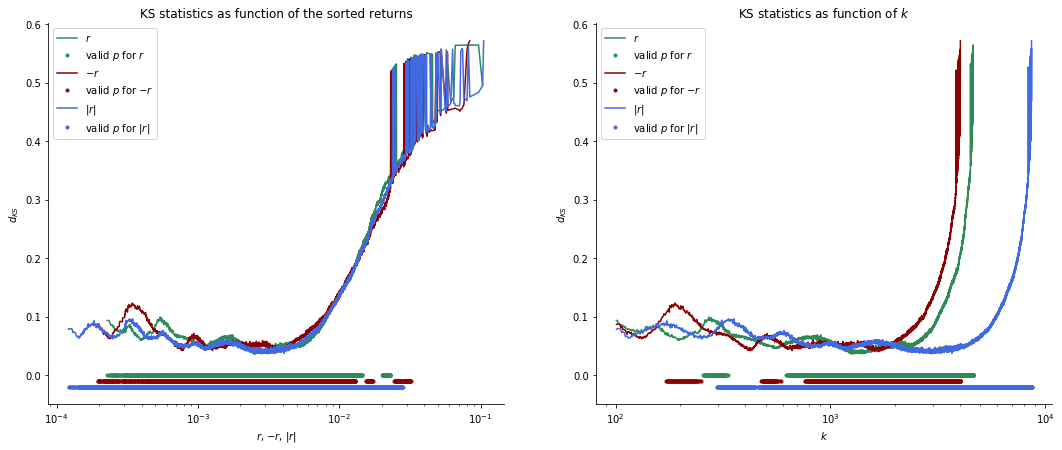

In [52]:
# plot della statistica KS al variare del sorted return e di k
truncation = 100
p_labels = {
    'pos': r'valid $p$ for $r$',
    'neg': r'valid $p$ for $-r$',
    'abs': r'valid $p$ for $|r|$',
}

fig, ax = pl.subplots(nrows=1, ncols=2, figsize=(18, 7))

# d_KS in funzione dei returns
for ret_type in return_type:
    x = sorted_lr.values[1:][::-1][truncation:]
    y = kolmog_smirn[ret_type]['ks']
    mask = valid_pvals[ret_type]
    k_ok = x[mask[::-1]]
    
    ax[0].semilogx(x, y, color=colors[ret_type], label=labels[ret_type])
    
    ax[0].semilogx(
        k_ok,
        np.zeros((len(k_ok, ))),
        color=colors[ret_type],
        marker='.',
        linestyle='',
        label=p_labels[ret_type]
    )

# y_pos = ks_pos[truncation:]
# x_pos = sorted_positive_lr.values[1:][::-1][truncation:]
# mask_pos = valid_pvals_pos[truncation:]
# ax[0].semilogx(x_pos, y_pos, color=colors['pos'], label='$r$')
# k_ok = x_pos[mask_pos[::-1]]
# ax[0].semilogx(
#     k_ok,
#     np.zeros((len(k_ok))),
#     color=colors['pos'],
#     marker='.',
#     linestyle='',
#     label=r'valid $p$ for $r$'
# )

# y_neg = ks_neg[truncation:]
# x_neg = sorted_negative_lr.values[1:][::-1][truncation:]
# mask_neg = valid_pvals_neg[truncation:]
# ax[0].semilogx(x_neg, y_neg, color=colors['neg'], label='$-r$')
# k_ok = x_neg[mask_neg[::-1]]
# ax[0].semilogx(
#     k_ok,
#     -0.01 * np.ones((len(k_ok))),
#     color=colors['neg'],
#     marker='.',
#     linestyle='',
#     label=r'valid $p$ for $-r$'
# )

# y_abs = ks_abs[truncation:]
# x_abs = sorted_absolute_lr.values[1:][::-1][truncation:]
# mask_abs = valid_pvals_abs[truncation:]
# ax[0].semilogx(x_abs, y_abs, color=colors['abs'], label='$|r|$')
# k_ok = x_abs[mask_abs[::-1]]
# ax[0].semilogx(
#     k_ok,
#     -0.02 * np.ones((len(k_ok))),
#     color=colors['abs'],
#     marker='.',
#     linestyle='',
#     label=r'valid $p$ for $|r|$'
# )

ax[0].set(
    xlabel=r'$r$, $-r$, $|r|$',
    ylabel=r'$d_{KS}$',
    title=r'KS statistics as function of the sorted returns'
)
ax[0].legend()


# d_KS in funzione di k
y_pos = ks_pos[truncation:]
x_pos = k_hill_pos[truncation:]
ax[1].semilogx(x_pos, y_pos, color=colors['pos'], label='$r$')
k_ok = k_hill_pos[valid_pvals_pos]
ax[1].semilogx(
    k_ok,
    np.zeros(len(k_ok)),
    color=colors['pos'],
    marker='.',
    linestyle='',
    label=r'valid $p$ for $r$'
)

y_neg = ks_neg[truncation:]
x_neg = k_hill_neg[truncation:]
ax[1].semilogx(x_neg, y_neg, color=colors['neg'], label='$-r$')
k_ok = k_hill_neg[valid_pvals_neg]
ax[1].semilogx(
    k_ok,
    -0.01 * np.ones(len(k_ok)),
    color=colors['neg'],
    marker='.',
    linestyle='',
    label=r'valid $p$ for $-r$'
)

y_abs = ks_abs[truncation:]
x_abs = k_hill_abs[truncation:]
ax[1].semilogx(x_abs, y_abs, color=colors['abs'], label='$|r|$')
k_ok = k_hill_abs[valid_pvals_abs]
ax[1].semilogx(
    k_ok,
    -0.02 * np.ones(len(k_ok)),
    color=colors['abs'],
    marker='.',
    linestyle='',
    label=r'valid $p$ for $|r|$'
)

ax[1].set(
    xlabel=r'$k$',
    ylabel=r'$d_{KS}$',
    title=r'KS statistics as function of $k$'
)
ax[1].legend()

sns.despine()

Le linee sottostanti le figure, composte in realtà da punti, identificano quei valori per cui il test di Kolmogorov-Smirnov ha dato un _p_-value $p \leq 0.05$, ed è quindi ritenuto statisticamente valido. Si nota come agli estremi di $k$ e dei returns il *p*-value non sia significativo e ci siano grosse oscillazioni, probabilmente dovute a instabilità numeriche nel calcolo della maximum likelihood.

### 3.4 Minima $d_{KS}$ per trovare il miglior fit della GEV

Ottimo, ora bisogna selezionare il minimo valore della statistica KS $d_{KS}$ che abbia un p-value valido ($p < 0.05$).

In [53]:
def find_min_dks(d_ks, pvals, min_pval=min_pval):
    dks = d_ks.copy()
    invalid = pvals > min_pval
    
    dks[invalid] = np.min(dks) + 1
    i_min = np.argmin(dks)
    
    return dks[i_min], i_min

In [54]:
min_dks_pos, i_min_dks_pos = find_min_dks(ks_pos, pvals_pos)
min_dks_neg, i_min_dks_neg = find_min_dks(ks_neg, pvals_neg)
min_dks_abs, i_min_dks_abs = find_min_dks(ks_abs, pvals_abs)

pos_threshold = sorted_positive_lr[i_min_dks_pos]
neg_threshold = -sorted_negative_lr[i_min_dks_neg]
abs_threshold = sorted_absolute_lr[i_min_dks_abs]

threshold_evt = {
    'pos': pos_threshold,
    'neg': neg_threshold,
    'abs': abs_threshold,
}

print("")
title_format = "{:>15}"*4
row_format = "{:>15}{:>15.4f}{:>15}{:>15.6f}"
print(title_format.format('Return type', 'Min d_KS', 'i', 'Return'))
print("-"*60)
print(row_format.format('positive', min_dks_pos, i_min_dks_pos, threshold_evt['pos']))
print(row_format.format('negative', min_dks_neg, i_min_dks_neg, threshold_evt['neg']))
print(row_format.format('absolute', min_dks_abs, i_min_dks_abs, threshold_evt['abs']))


    Return type       Min d_KS              i         Return
------------------------------------------------------------
       positive         0.0385           1466       0.008062
       negative         0.0407           1680      -0.006099
       absolute         0.0365           2918       0.007654


Vediamo graficamente se le distribuzioni fittano bene i dati:

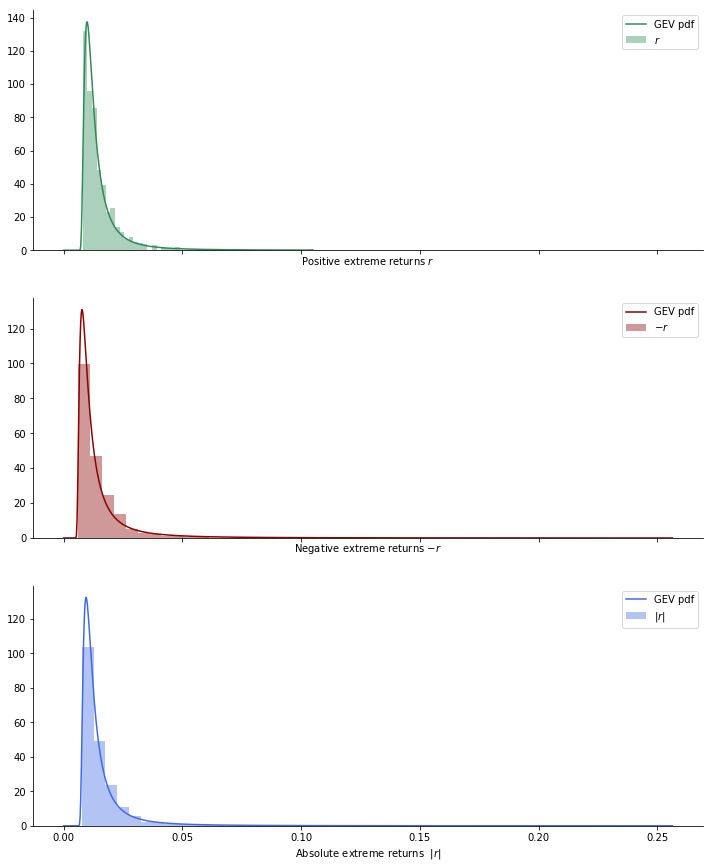

In [55]:
# preparo i dati per plottare
titles = ['Positive extreme returns', 'Negative extreme returns', 'Absolute extreme returns']
xlabels = [r'Positive extreme returns $r$', r'Negative extreme returns $-r$', r'Absolute extreme returns  $|r|$']
order = ['pos', 'neg', 'abs']
data = {
    'pos': sorted_positive_lr.values[:i_min_dks_pos],
    'neg': sorted_negative_lr.values[:i_min_dks_neg],
    'abs': sorted_absolute_lr.values[:i_min_dks_abs],
}
i_min_dks = {
    'pos': i_min_dks_pos,
    'neg': i_min_dks_neg,
    'abs': i_min_dks_abs,
}
labels = {
    'pos': r'$r$',
    'neg': r'$-r$',
    'abs': r'$|r|$',
}

# plot
fig, ax = pl.subplots(nrows=3, ncols=1, figsize=(12, 15), sharex=True)

for a, ret_type, xlabel in zip(ax, order, xlabels):
    sns.distplot(
        data[ret_type],
        color=colors[ret_type],
        label=labels[ret_type],
        kde=False,
        norm_hist=True,
        ax=a)
    a.set_xlabel(xlabel)

for a, ret_type in zip(ax, order):
    i_min = i_min_dks[ret_type]
    best_fit = fits[ret_type][i_min]
    _, b = a.xaxis.get_data_interval()
    x = np.linspace(0, b, 1000)
    pdf = gev.pdf(x, *best_fit)
    a.plot(x, pdf, color=colors[ret_type], label='GEV pdf')
    a.legend()

sns.despine()

Ottimo, sembra che fittino piuttosto bene. A questo punto é finita la sezione 4.1 del paper.

Finora abbiamo quindi ottenuto:

- le distribuzioni di probabilità degli extreme returns (positivi, negativi, assoluti)
- i threshold che massimizzano il fitting della distribuzione *GEV* sugli extreme returns. Tali threshold possono essere quindi usati per determinare quali movimenti siano estremi e quali no!

Concludiamo quindi confrontando i threshold così ottenuti con i threshold del 95% percentile che abbiamo utilizzato finora per le azioni S&P500.

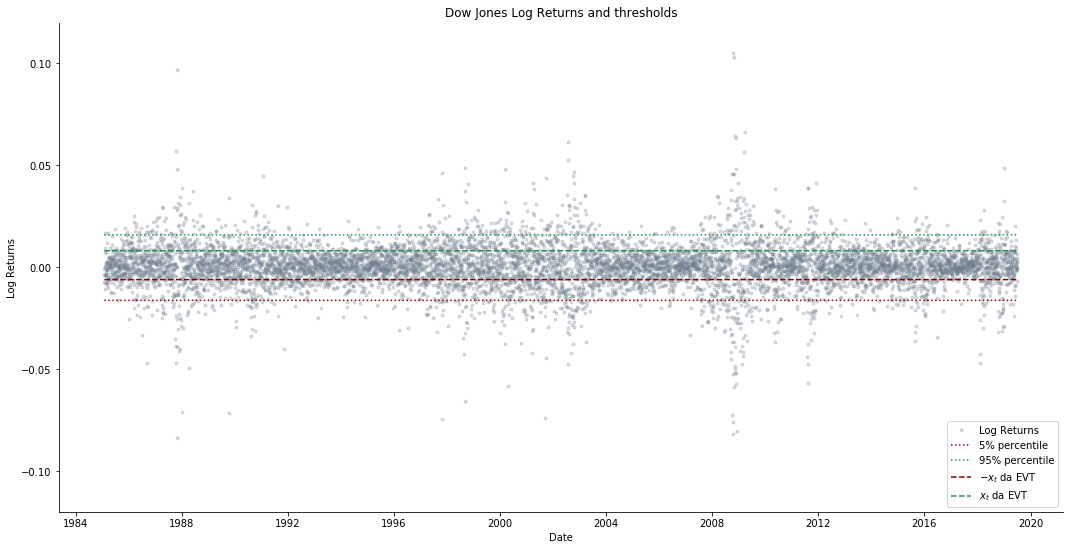

In [56]:
perc = log_returns['Adj Close'].quantile(q=[0.05, 0.95])

fig, ax = pl.subplots(nrows=1, ncols=1, figsize=(18, 9))

dates = log_returns.index
ax.plot(log_returns['Adj Close'], label='Log Returns', color='slategrey', alpha=0.25, linestyle='', marker='.')
ax.plot(dates, perc[0.05] * np.ones(len(dates)), color=colors['neg'], linestyle=':', label='5% percentile')
ax.plot(dates, perc[0.95] * np.ones(len(dates)), color=colors['pos'], linestyle=':', label='95% percentile')
ax.plot(dates, neg_threshold * np.ones(len(dates)), color=colors['neg'], linestyle='--', label=r'$-x_t$ da EVT')
ax.plot(dates, pos_threshold * np.ones(len(dates)), color=colors['pos'], linestyle='--', label=r'$x_t$ da EVT')

ax.set(xlabel='Date', ylabel='Log Returns', title='Dow Jones Log Returns and thresholds', ylim=[-0.12, 0.12])
ax.legend(loc='lower right')

sns.despine()

Come si può vedere dal plot, i percentili sono molto più stringenti rispetto al valore che massimizza il fitting della *GEV*. Vediamo anche di confermarlo con un po' di numeri:

In [57]:
extreme_percent_with_percentiles = len(log_returns['Adj Close'][(log_returns['Adj Close'] <= perc[0.05]) | (log_returns['Adj Close'] >= perc[0.95])]) / len(log_returns)
extreme_percent_with_gev = len(log_returns['Adj Close'][(log_returns['Adj Close'] <= threshold_evt['neg']) | (log_returns['Adj Close'] >= threshold_evt['pos'])]) / len(log_returns)

print("{:>20}{:>15}".format('Threshold type', 'Extremes %'))
print("-"*35)
print("{:>20}{:>15.3f}".format('percentile 5-95 %', extreme_percent_with_percentiles))
print("{:>20}{:>15.3f}".format('EVT', extreme_percent_with_gev))

      Threshold type     Extremes %
-----------------------------------
   percentile 5-95 %          0.100
                 EVT          0.363


In pratica, vuol dire che se usassimo i valori di threshold ricavati dalla *EVT* avremmo un dataset sicuramente più bilanciato, ma c'è da chiedersi se si possano effettivamente allora considerare "estremi". Non è troppo "inclusivo" un tale threshold?

### 3.5 Calcolo dei $\tau_Q$ e delle $Q$

Calcoliamoli per poi usarli nella maximum likelihood estimation.

In [67]:
# creo i tau e calcolo i Q
tau_q_95 = 1.0 / (1.0 - 0.95)
tau_q_975 = 1.0 / (1.0 - 0.975)
tau_q_99 = 1.0 / (1.0 - 0.99)

def compute_Q(lr, thresh):
    """lr and thresh must have the same sign."""

# calcolo i quantili equivalenti ai threshold della EVT
Q_evt_pos = 1.0 - (sum(positive_lr >= threshold_evt['pos']) / len(positive_lr))
Q_evt_neg = 1.0 - (sum(negative_lr <= threshold_evt['neg']) / len(negative_lr))
Q_evt_abs = 1.0 - (sum(absolute_lr >= threshold_evt['abs']) / len(absolute_lr))

Q = {
    'pos': Q_evt_pos,
    'neg': Q_evt_neg,
    'abs': Q_evt_abs,
}

tau_q = {
    '95': tau_q_95,
    '97.5': tau_q_975,
    '99': tau_q_99,
    'pos': 1.0 / (1.0 - Q['pos']),
    'neg': 1.0 / (1.0 - Q['neg']),
    'abs': 1.0 / (1.0 - Q['abs']),
}

## 4. Calcolo degli intervalli di ricorrenza e plot della loro distribuzione

Ora che abbiamo i threshold possiamo calcolare gli intervalli di ricorrenza e vederne la distribuzione.

In [68]:
def get_recurrence_intervals(is_extreme: pd.DataFrame):
    """Get the recurrence intervals durations between extremes.
    
    Parameters
    ----------
    is_extreme: pd.DataFrame
        a DataFrame with the date on the index and 1 if the return at time t is extreme,
        0 otherwise. Must contain a single column named 'extreme'
    """
    assert isinstance(is_extreme.index, pd.DatetimeIndex)
    assert len(is_extreme.columns) == 1
    
    # convert to int
    data = is_extreme.astype(np.int8)
    data.loc[:, 'date'] = data.index
    data.index = pd.RangeIndex(len(is_extreme))
    
    data_is_extreme = data[data[data.columns[0]] == 1]
    
    intervals = []
    for i in range(1, len(data_is_extreme)):
        last_time = data_is_extreme.date.iloc[i - 1]
        current_time = data_is_extreme.date.iloc[i]
        
        n_days = data_is_extreme.index[i] - data_is_extreme.index[i - 1]
        
        intervals.append((last_time, current_time, n_days))
        
    return intervals

I quantili vanno presi al 95%, 97.5%, 99%. Di conseguenza creo `lr_extremes` che contiene su una colonna i log returns, le altre invece sono colonne binarie che identificano i movimenti come estremi o no al tempo *t*.

In [69]:
quantiles_absolute = log_returns.abs().quantile(q=[0.95, 0.975, 0.99]).rename(columns={'Adj Close': 'abs'})
quantiles_negative = -(-log_returns).quantile(q=[0.95, 0.975, 0.99]).rename(columns={'Adj Close': 'neg'})
quantiles_positive = log_returns.quantile(q=[0.95, 0.975, 0.99]).rename(columns={'Adj Close': 'pos'})

quantiles_df = pd.concat([quantiles_positive, quantiles_negative, quantiles_absolute], axis='columns')

lr_extremes = log_returns.copy(deep=True)

lr_extremes.loc[:, 'abs_95'] = (log_returns.abs() > quantiles_df.loc[0.95, 'abs'])['Adj Close'].values.astype(np.int8)
lr_extremes.loc[:, 'pos_95'] = (log_returns > quantiles_df.loc[0.95, 'pos'])['Adj Close'].values.astype(np.int8)
lr_extremes.loc[:, 'neg_95'] = (log_returns < quantiles_df.loc[0.95, 'neg'])['Adj Close'].values.astype(np.int8)

lr_extremes.loc[:, 'abs_97.5'] = (log_returns.abs() > quantiles_df.loc[0.975, 'abs'])['Adj Close'].values.astype(np.int8)
lr_extremes.loc[:, 'pos_97.5'] = (log_returns > quantiles_df.loc[0.975, 'pos'])['Adj Close'].values.astype(np.int8)
lr_extremes.loc[:, 'neg_97.5'] = (log_returns < quantiles_df.loc[0.975, 'neg'])['Adj Close'].values.astype(np.int8)

lr_extremes.loc[:, 'abs_99'] = (log_returns.abs() > quantiles_df.loc[0.99, 'abs'])['Adj Close'].values.astype(np.int8)
lr_extremes.loc[:, 'pos_99'] = (log_returns > quantiles_df.loc[0.99, 'pos'])['Adj Close'].values.astype(np.int8)
lr_extremes.loc[:, 'neg_99'] = (log_returns < quantiles_df.loc[0.99, 'neg'])['Adj Close'].values.astype(np.int8)

lr_extremes.loc[:, 'pos_evt'] = (log_returns > threshold_evt['pos'])['Adj Close'].values.astype(np.int8)
lr_extremes.loc[:, 'neg_evt'] = (log_returns < -threshold_evt['neg'])['Adj Close'].values.astype(np.int8)
lr_extremes.loc[:, 'abs_evt'] = (log_returns.abs() > threshold_evt['abs'])['Adj Close'].values.astype(np.int8)

Per comodità metto tutto in un `dict`, così da accedere facile:

In [70]:
# return_type = ['pos', 'neg', 'abs']
# quantile_type = ['95', '97.5', '99', 'evt']

threshold = {
    q_type: {
        ret_type: quantiles_df.loc[float(q_type) / 100.0, ret_type]
        for ret_type in return_type
    }
    for q_type in quantile_type[:-1]
}
threshold['evt'] = threshold_evt

tmp_recurrence_intervals = {
    ret_type: {
        q_type: get_recurrence_intervals(lr_extremes[[ret_type + '_' + q_type]])
        for q_type in quantile_type
    }
    for ret_type in return_type
}

recurrence_intervals = {
    ret_type: {
        q_type: pd.DataFrame(data={
            'last_extreme': [x[0] for x in tmp_recurrence_intervals[ret_type][q_type]],
            'current_extreme': [x[1] for x in tmp_recurrence_intervals[ret_type][q_type]],
            'n_days': [x[2] for x in tmp_recurrence_intervals[ret_type][q_type]],
        })
        for q_type in quantile_type
    }
    for ret_type in return_type
}

### 4.1 Plot istogrammi intervalli di ricorrenza

Ora visualizzo graficamente la lunghezza degli intervalli di ricorrenza con degli istogrammi, rispettivamente per i returns positivi, negativi ed assoluti.

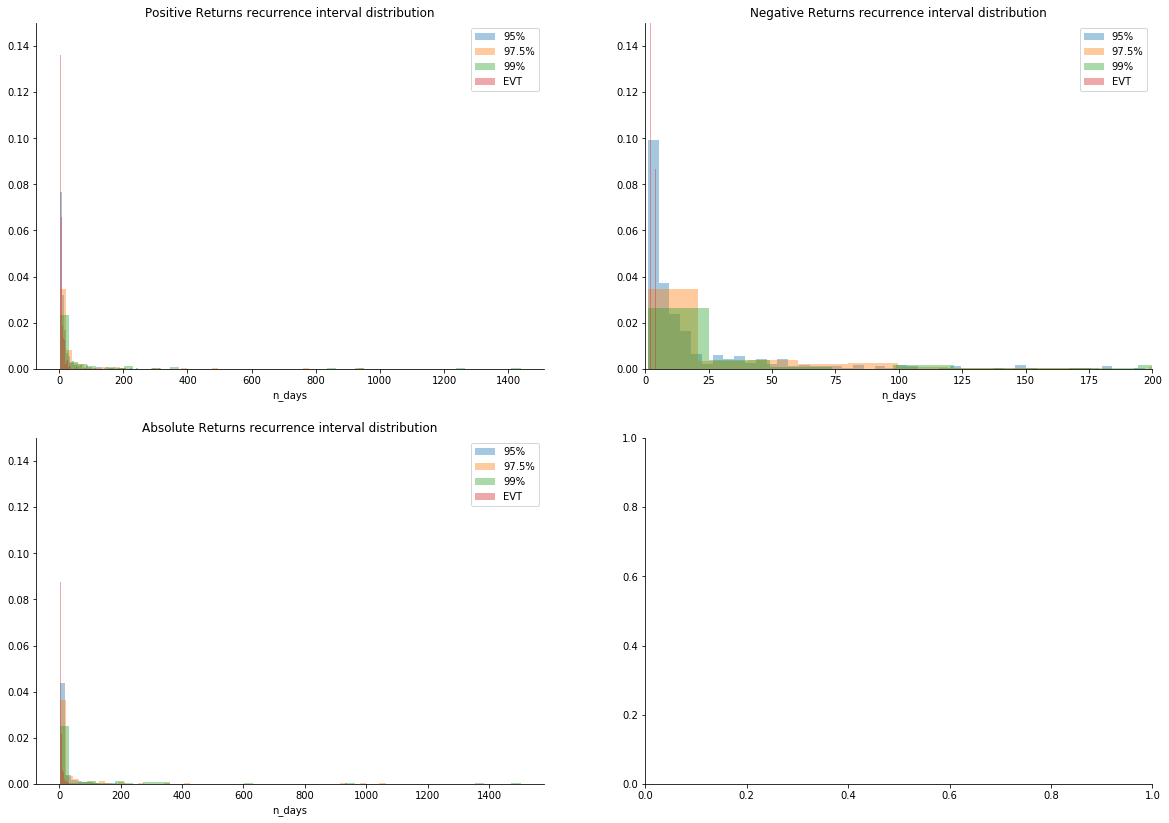

In [71]:
fig, ax = pl.subplots(nrows=2, ncols=2, figsize=(20, 14))

# positive returns
curr = recurrence_intervals['pos']['95'].n_days
sns.distplot(curr, kde=False, norm_hist=True, label='95%', ax=ax[0][0])

curr = recurrence_intervals['pos']['97.5'].n_days
sns.distplot(curr, kde=False, norm_hist=True, label='97.5%', ax=ax[0][0])

curr = recurrence_intervals['pos']['99'].n_days
sns.distplot(curr, kde=False, norm_hist=True, label='99%', ax=ax[0][0])

curr = recurrence_intervals['pos']['evt'].n_days
sns.distplot(curr, kde=False, norm_hist=True, label='EVT', ax=ax[0][0])

ax[0][0].legend()
ax[0][0].set(title='Positive Returns recurrence interval distribution', ylim=[0.0, 0.15])
sns.despine()

# negative returns
curr = recurrence_intervals['neg']['95'].n_days
sns.distplot(curr, kde=False, norm_hist=True, label='95%', ax=ax[0][1])

curr = recurrence_intervals['neg']['97.5'].n_days
sns.distplot(curr, kde=False, norm_hist=True, label='97.5%', ax=ax[0][1])

curr = recurrence_intervals['neg']['99'].n_days
sns.distplot(curr, kde=False, norm_hist=True, label='99%', ax=ax[0][1])

curr = recurrence_intervals['neg']['evt'].n_days
sns.distplot(curr, kde=False, norm_hist=True, label='EVT', ax=ax[0][1])

ax[0][1].legend()
ax[0][1].set(title='Negative Returns recurrence interval distribution', ylim=[0.0, 0.15], xlim=[0.0, 200])
# zoomato sennò non si vede un accidente
sns.despine()

# absolute returns
curr = recurrence_intervals['abs']['95'].n_days
sns.distplot(curr, kde=False, norm_hist=True, label='95%', ax=ax[1][0])

curr = recurrence_intervals['abs']['97.5'].n_days
sns.distplot(curr, kde=False, norm_hist=True, label='97.5%', ax=ax[1][0])

curr = recurrence_intervals['abs']['99'].n_days
sns.distplot(curr, kde=False, norm_hist=True, label='99%', ax=ax[1][0])

curr = recurrence_intervals['abs']['evt'].n_days
sns.distplot(curr, kde=False, norm_hist=True, label='EVT', ax=ax[1][0])

ax[1][0].legend()
ax[1][0].set(title='Absolute Returns recurrence interval distribution', ylim=[0.0, 0.15])

sns.despine()

### 4.2 Creazione delle tabelle come nel paper

Ora creo le tabelle riassuntive come a pagina 9 del paper di [Jiang et al](https://doi.org/10.1080/14697688.2017.1373843).

Prima mi creo due funzioncine e poi le chiamo.

In [72]:
def get_single_table(intervals: pd.DataFrame, returns: pd.DataFrame, ret_type: str, thresh: float, col_name='perc'):
    """Get a single panel sub-table."""
    obsv = int(intervals.shape[0])
    mean = intervals['n_days'].mean()
    median = intervals['n_days'].median()
    std_dev = intervals['n_days'].std()
    skewness = intervals['n_days'].skew()
    kurtosis = intervals['n_days'].kurt()
    
    ret_mean = returns.mean()
    ret_std_dev = returns.std()
    
    if ret_type == 'neg':
        m = (ret_mean - thresh) / ret_std_dev
    else:
        m = (thresh - ret_mean) / ret_std_dev
        
    acf, qstat, pvals = stattools.acf(intervals['n_days'].values, qstat=True, nlags=30)
    rho1 = acf[1]
    _, p_rho1 = scipy.stats.pearsonr(
        intervals['n_days'].values[1:],
        intervals['n_days'].shift(periods=1).values[1:],
    )
    
    rho5 = acf[5]
    _, p_rho5 = scipy.stats.pearsonr(
        intervals['n_days'].values[5:],
        intervals['n_days'].shift(periods=5).values[5:],
    )

    Q30 = qstat[-1]
    p_Q30 = pvals[-1]
    
    index = pd.Index(data=[
        'm',
        'obsv',
        'mean',
        'median',
        'stdev',
        'skew',
        'kurt',
        'rho(1)',
        'p-value(rho1)',
        'rho(5)',
        'p-value(rho5)',
        'Q(30)',
        'p-value(Q30)',
    ])
    
    result = pd.DataFrame(data=[
        [m],
        [obsv],
        [mean],
        [median],
        [std_dev],
        [skewness],
        [kurtosis],
        [rho1],
        [p_rho1],
        [rho5],
        [p_rho5],
        [Q30],
        [p_Q30],
    ],
    index=index,
    columns=[col_name])
    
    return result

Il titolo è la sezione della tabella (Negative/Positive/Absolute), i quantili sono quelli che mi interessano e finiranno sulle colonne della tabella ed il risultato è un `dict` che ha come chiavi i titoli.

In [73]:
tables = {
    ret_type: {
        q_type: get_single_table(recurrence_intervals[ret_type][q_type],
                                 returns[ret_type],
                                 ret_type,
                                 thresh=threshold[q_type][ret_type],
                                 col_name=q_type)
        for q_type in quantile_type
    }
    for ret_type in return_type
}

panels = {
    ret_type: pd.concat([tables[ret_type][q_type] for q_type in quantile_type], axis='columns')
    for ret_type in return_type
}

Visualizziamo le tabelle:

In [74]:
panels['pos']

,95,97.5,99,evt
m,1.179692e+00,1.817781,2.840824,1.246931e-01
obsv,4.330000e+02,216.000000,86.000000,1.465000e+03
mean,1.996536e+01,38.300926,93.058140,5.913993e+00
median,8.000000e+00,10.000000,11.000000,4.000000e+00
stdev,3.672516e+01,99.249215,244.902351,6.445609e+00
skew,4.038396e+00,6.323296,4.110145,3.442478e+00
kurt,1.968695e+01,47.973991,17.628643,2.216887e+01
rho(1),3.277903e-01,0.222210,0.100576,1.690871e-01
p-value(rho1),2.453529e-12,0.001030,0.359132,7.417536e-11
rho(5),1.967495e-01,-0.011594,0.016122,1.288250e-01


In [75]:
panels['neg']

,95,97.5,99,evt
m,9.667559e-01,1.574701,2.460536,-1.448152e-01
obsv,4.330000e+02,216.000000,86.000000,6.701000e+03
mean,1.965358e+01,38.907407,95.023256,1.294881e+00
median,7.000000e+00,8.000000,12.000000,1.000000e+00
stdev,3.275859e+01,93.786897,203.543548,6.036351e-01
skew,3.125221e+00,6.355142,3.441272,2.316338e+00
kurt,1.094604e+01,53.754844,12.961113,6.047815e+00
rho(1),3.202931e-01,0.191087,0.200588,3.830820e-02
p-value(rho1),6.019181e-12,0.004885,0.065458,1.709169e-03
rho(5),1.701166e-01,0.025373,0.028988,3.840730e-02


In [76]:
panels['abs']

,95,97.5,99,evt
m,1.677221,2.353180,3.568658,4.802457e-02
obsv,433.000000,216.000000,86.000000,2.917000e+03
mean,19.408776,37.925926,94.639535,2.970175e+00
median,5.000000,5.000000,4.000000,2.000000e+00
stdev,58.753145,126.650899,254.288022,3.291632e+00
skew,10.105742,6.364142,4.165665,4.154769e+00
kurt,139.524134,44.820606,18.830794,2.816741e+01
rho(1),0.223946,0.055943,0.128472,2.519868e-01
p-value(rho1),0.000002,0.414315,0.239329,1.769324e-43
rho(5),0.072817,0.079881,-0.052729,1.990622e-01


### 4.3 Plot degli autocorrelogrammi

Vediamo con gli [autocorrelogammi](https://en.wikipedia.org/wiki/Correlogram) se c'è autocorrelazione nelle serie dei *recurrence interval*.

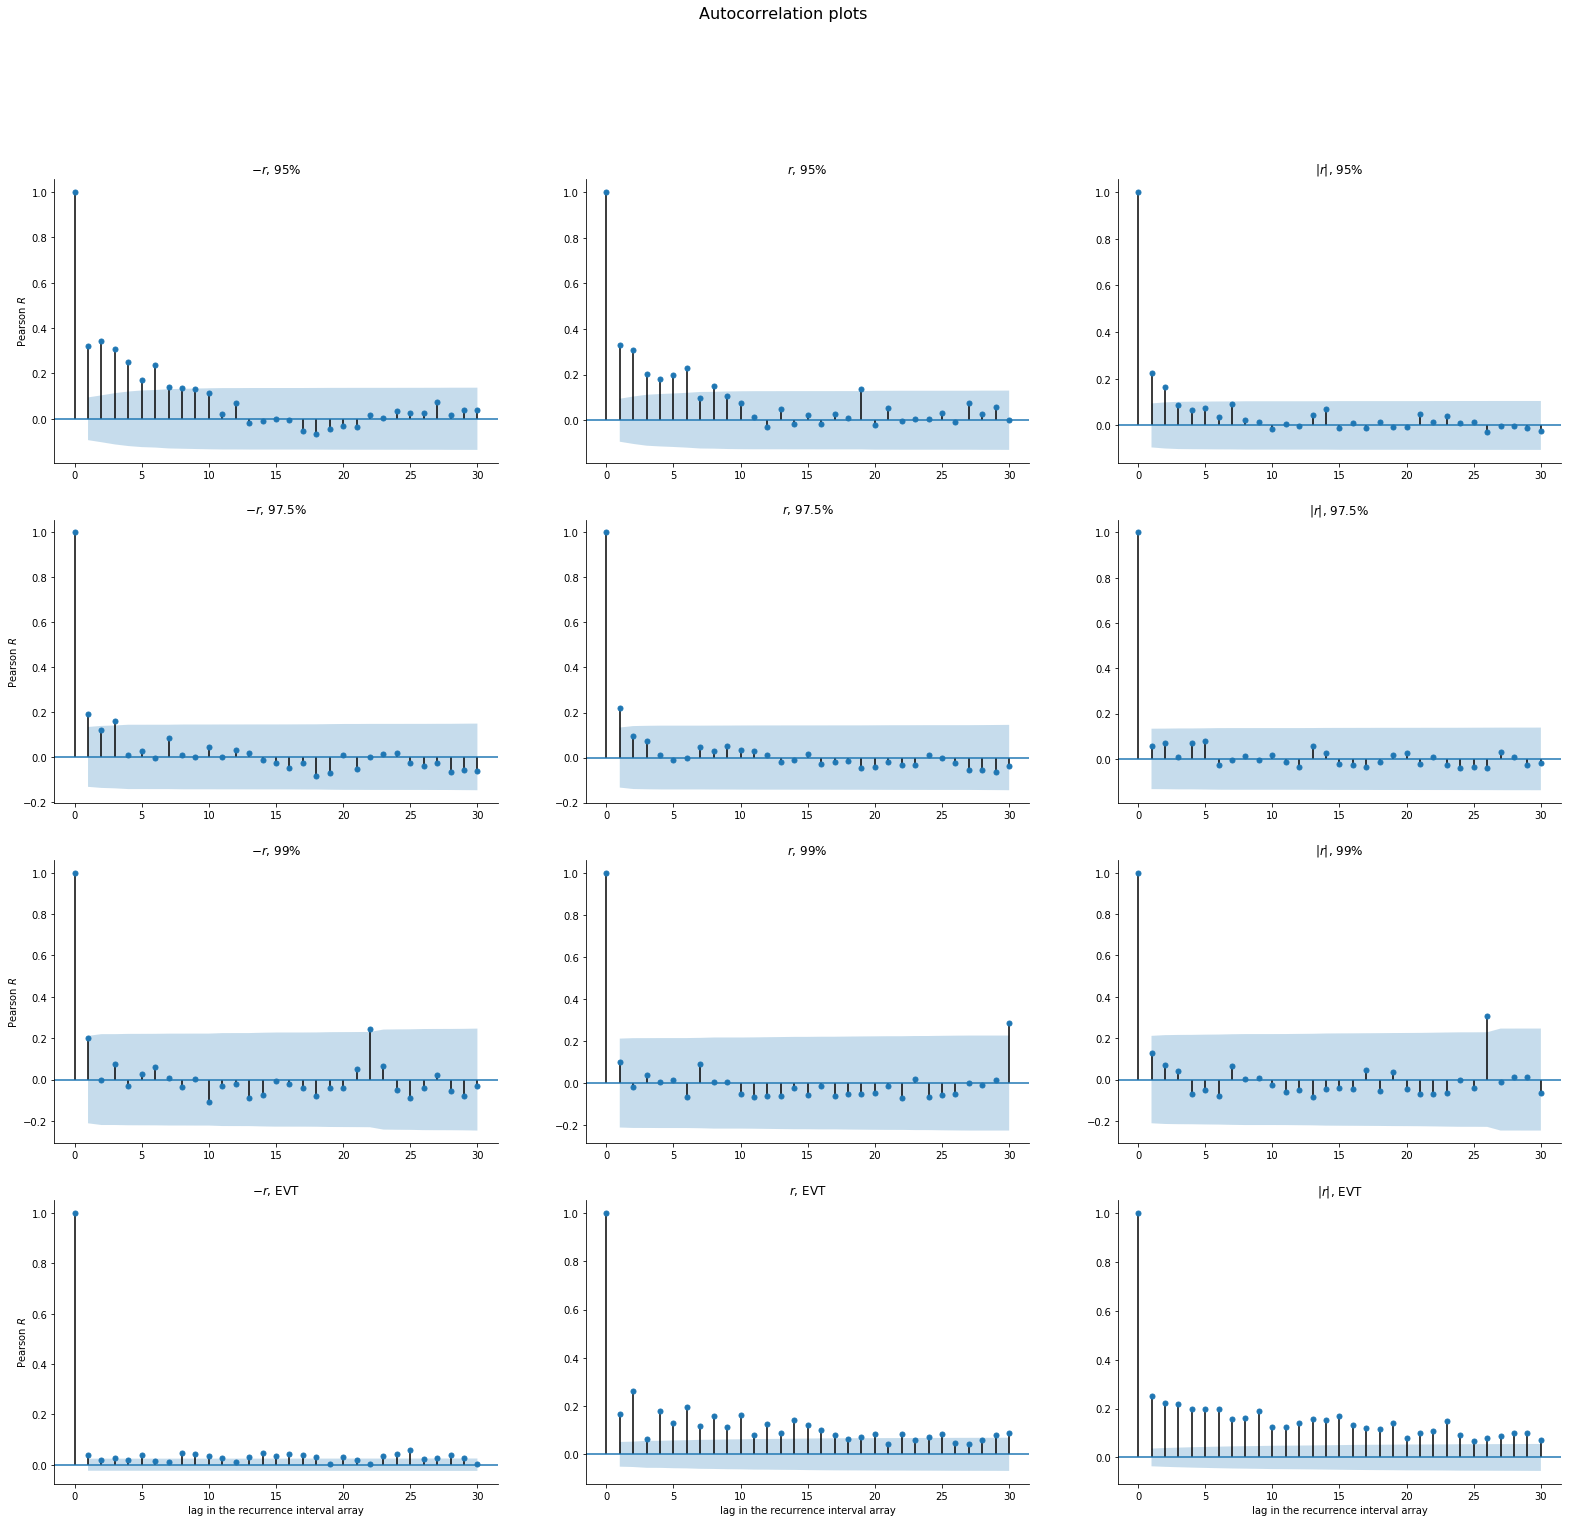

In [77]:
# sulle righe il tipo di threshold, sulle colonne il tipo di return
fig, ax = pl.subplots(nrows=4, ncols=3, figsize=(27, 24))
fig.suptitle("Autocorrelation plots", fontsize=16)

tsaplots.plot_acf(recurrence_intervals['neg']['95']['n_days'].values, lags=30, ax=ax[0][0], title=r'$-r$, 95%')
tsaplots.plot_acf(recurrence_intervals['pos']['95']['n_days'].values, lags=30, ax=ax[0][1], title=r'$r$, 95%')
tsaplots.plot_acf(recurrence_intervals['abs']['95']['n_days'].values, lags=30, ax=ax[0][2], title=r'$|r|$, 95%')
ax[0, 0].set_ylabel("Pearson $R$")

tsaplots.plot_acf(recurrence_intervals['neg']['97.5']['n_days'].values, lags=30, ax=ax[1][0], title=r'$-r$, 97.5%')
tsaplots.plot_acf(recurrence_intervals['pos']['97.5']['n_days'].values, lags=30, ax=ax[1][1], title=r'$r$, 97.5%')
tsaplots.plot_acf(recurrence_intervals['abs']['97.5']['n_days'].values, lags=30, ax=ax[1][2], title=r'$|r|$, 97.5%')
ax[1, 0].set_ylabel("Pearson $R$")

tsaplots.plot_acf(recurrence_intervals['neg']['99']['n_days'].values, lags=30, ax=ax[2][0], title=r'$-r$, 99%')
tsaplots.plot_acf(recurrence_intervals['pos']['99']['n_days'].values, lags=30, ax=ax[2][1], title=r'$r$, 99%')
tsaplots.plot_acf(recurrence_intervals['abs']['99']['n_days'].values, lags=30, ax=ax[2][2], title=r'$|r|$, 99%')
ax[2, 0].set_ylabel("Pearson $R$")

tsaplots.plot_acf(recurrence_intervals['neg']['evt']['n_days'].values, lags=30, ax=ax[3][0], title=r'$-r$, EVT')
tsaplots.plot_acf(recurrence_intervals['pos']['evt']['n_days'].values, lags=30, ax=ax[3][1], title=r'$r$, EVT')
tsaplots.plot_acf(recurrence_intervals['abs']['evt']['n_days'].values, lags=30, ax=ax[3][2], title=r'$|r|$, EVT')
ax[3, 0].set_ylabel("Pearson $R$")

for a in ax[3]:
    a.set_xlabel('lag in the recurrence interval array')

sns.despine()

Per interpretare i plot, bisogna ricordare che:

- sulle $x$ c'è il lag della serie temporale relativa ai giorni tra i movimenti estremi, cioè quella degli intervalli di ricorrenza. Vuol dire che $x=22$ significa il 22° intervallo di ricorrenza visto nel passato, prima di quello attuale, non 22 giorni prima di oggi. La distanza in giorni potrebbe anche essere un anno o più.
- sulle y c'è la correlazione di Pearson $R$

Apparentemente c'è autocorrelazione nei recurrence intervals selezionati con il quantile $q_{0.95}$ fino a 6 per positivi e negativi, 2 per gli assoluti.

Per i recurrence intervals con $q_{0.975}$ solo a 1 giorno per positivi e negativi, nessuna per gli assoluti.

Per i recurrence intervals con $q_{0.99}$ non c'è autocorrelazione.

### 4.4 Verifica relazione empirica

Verifichiamo ora la relazione empirica $\tau_Q = \frac{Q}{1 - Q}$ dove $Q$ è il quantile scelto (0.95, 0.975, 0.99), $\tau_Q$ l'intervallo di ricorrenza medio

In [78]:
title_format = "{:>15}"*5
row_format = "{:>15.3f}{:>15}{:>15.3f}{:>15.3f}" + "{:>14.3f}%"
print(title_format.format('Quantile', 'Return type', 'tau_q', 'True mean', 'Error %'))
print(title_format.format('-'*15, '-'*15, '-'*15, '-'*15, '-'*15))

for q_type in quantile_type[:-1]:
    for i, name in enumerate(return_type):
        data_mean = recurrence_intervals[name][q_type]['n_days'].mean()
        
        q = float(q_type) / 100.0
        tau = 1.0 / (1.0 - q)
        
        perc_diff = (tau - data_mean) / data_mean
        
        print(row_format.format(q, name, tau, data_mean, perc_diff * 100))
        
        if i == len(return_type) - 1:
            print("")

       Quantile    Return type          tau_q      True mean        Error %
---------------------------------------------------------------------------
          0.950            pos         20.000         19.965         0.174%
          0.950            neg         20.000         19.654         1.763%
          0.950            abs         20.000         19.409         3.046%

          0.975            pos         40.000         38.301         4.436%
          0.975            neg         40.000         38.907         2.808%
          0.975            abs         40.000         37.926         5.469%

          0.990            pos        100.000         93.058         7.460%
          0.990            neg        100.000         95.023         5.237%
          0.990            abs        100.000         94.640         5.664%



In effetti, la relazione è valida con un margine di errore massimo di circa il $5\%$.

# 5. Determinazione della probabilità di pericolo - TODO

Gli autori definiscono la *hazard probability* come

\begin{equation}
    W(\Delta t | t) = \frac{\int_t^{t + \Delta t} p(\tau)d\tau}{\int_t^{\infty}p(\tau)d\tau}
\end{equation}

dove $p(\tau)$ è la distribuzione di probabilità (`pdf` per scipy).

La hazard probability definisce la probabilità che, dato che si è verificato un evento estremo $t$ giorni nel passato, ci sia un tempo di attesa $\Delta t$ ulteriore prima di un altro evento estremo.
Se consideriamo $W(1 | t)$ è simile al problema che abbiamo affrontato con la rete neurale.

Ora, nota la ditribuzione $p(\tau)$, si può derivare analiticamente l'integrale. Il problema è quindi: come trovare $p(\tau)$, e che forma ha?

Gli autori utilizzano una [stretched exponential distribution](https://en.wikipedia.org/wiki/Stretched_exponential_function), una [*q*-exponential distribution](https://en.wikipedia.org/wiki/Q-exponential_distribution) ed una [Weibull distribution](https://it.wikipedia.org/wiki/Distribuzione_di_Weibull). I parametri delle 3 distribuzioni vengono stimati tramite MLE.

Il flusso è il seguente:

1. scegli una distribuzione (s-exp, q-exp, Weibull)
2. riformula la parametrizzazione in funzione solo  dello *shape parameter*
3. calcola la log-likelihood utilizzando una semplice ricerca a griglia sui parametri liberi
4. i parametri che forniscono la massima log-likelihood sono quelli cercati, e trova la formula teorica della *hazard probability* con le equazioni del paper

Cominciamo con la Weibull.

## 5.1 Fitting della Weibull

In `scipy.stats` è definita come

\begin{eqnarray}
&f(x, c) = c x^{c - 1} e^{-x^{c}} \\
&f(x, c, loc, scale) = \frac{1}{scale}f\left(\frac{x - loc}{scale}, c\right)
\end{eqnarray}

dove $c$ è lo *shape parameter*. Nel paper invece è

\begin{equation}
f(x, \beta, \alpha) = \frac{\alpha}{\beta} \left( \frac{\tau}{\beta} \right)^{\alpha - 1} e^{-\left( \frac{\tau}{\beta} \right)^{\alpha}}
\end{equation}

quindi la corrispondenza è

\begin{eqnarray}
&loc = 0 \\
&\beta = scale \\
&shape = c = \alpha
\end{eqnarray}

Ora dobbiamo stimare i parametri della Weibull con una maximum log-likelihood estimation (*MLE*). Riscrivendoli in funzione di $\tau_Q$ e $\beta = scale$ abbiamo

\begin{eqnarray}
&\beta = \frac{\tau_Q}{\Gamma \left( 1 + \frac{1}{\alpha} \right)} \\
cioè \\
&\beta = scale = \frac{\tau_Q}{\Gamma \left( 1 + \frac{1}{c} \right)}
\end{eqnarray}

Ricordiamo che $\tau_Q = \frac{1}{1 - Q}$ dove $Q$ è il quantile.

A questo punto la MLE ha formula:

$$ ln(L_w) = n \cdot ln\left( \frac{c}{\beta} \right) + \sum_{i=1}^{n} \left[ (c - 1) ln\left( \frac{\tau_i}{\beta} \right) - \left( \frac{\tau_i}{\beta} \right)^c \right] $$

dove $n$ è il numero di recurrence intervals, $t_i$ il corrispondente valore dell'intervallo di ricorrenza (es: 14 giorni, 4 giorni...).

Il flow è quindi, in questo caso:

1. a seconda del percentile (95% o EVT) calcolare $Q$ e quindi $\tau_Q$
2. utilizzare una ricerca con step $1e-6$ sul parametro $c = \alpha$, il quale risulta in un certo valore di $\beta$
3. utilizzare quei valori di $c$ e di $\beta$ nella MLE
4. trovare il massimo della MLE ed i corrispondenti valori di $c$ e $\beta$
5. urrà! Ora possiamo usarli nella *pdf* della distribuzione Weibull per ottenere l'hazard $W(\Delta t | t)$

Prima di cominciare voglio vedere quanto ci mette, quindi creo un piccolo decorator:

In [79]:
@timeit
@numba.jit(nopython=True, parallel=True, nogil=True)
def mle_weibull(rec_ints: np.ndarray, c: np.ndarray, beta: np.ndarray):
    """MLE estimation for weibull distribution, given an array of c shape parameters and the tau_q,
    with the recurrence intervals rec_ints.
    """       
    m = beta.shape[0]
    n = rec_ints.shape[0]

    # log-likelihood    
    log_likelihoods = np.zeros_like(beta)
    
    # precompute matrices for tau_beta and ln_tau_beta
    tau_beta = np.zeros((n, m), dtype=np.float64)
    for i in range(n):
        for j in range(m):
            tau_beta[i, j] = rec_ints[i] / beta[j]
            
    ln_tau_beta = np.log(tau_beta)
    
    c_beta = c / beta
    n_ln_c_beta = n * np.log(c_beta)
    c_1 = c - 1.0

    for j in numba.prange(m):  # no progress indication, it's a parallel for loop
        summ = 0
        
        for i in range(n):
            summ += c_1[j] * ln_tau_beta[i, j] - tau_beta[i, j] ** c[j]
            
        log_likelihoods[j] = n_ln_c_beta[j] + summ
        
    return log_likelihoods

Ora usiamo la funzione per calcolarci il fitting della Weibull per i returns positivi, negativi ed assoluti:

In [97]:
c = np.arange(0.25, 1.7, 1e-3)
sfg = sfun.gamma(1.0 + (1.0 / c))

beta = {k: v / sfg for k, v in tau_q.items()}
i_ok = {k: np.argwhere(beta[k] > 1e-6).flatten() for k in beta.keys()}

beta_ok = {k: beta[k][i_ok[k]] for k in beta.keys()}
c_ok = {k: c[i_ok[k]] for k in beta.keys()}

In [98]:
load_log_like = False

if load_log_like:
    with open('./log_like_weib.pickle', 'rb') as infile:
        log_like_weib = pickle.load(infile)
else:
    log_like_weib = dict()

    for ret_type in return_type:
        log_like_weib[ret_type] = dict()
        print(f"\nReturn type: {ret_type}")

        for q_type in quantile_type[:-1]:
            x = recurrence_intervals[ret_type][q_type]['n_days'].values
            print(f"Computing Weibull MLE on quantile: {q_type}, c={c_ok[q_type].shape}, beta={beta_ok[q_type].shape}")

            ll = mle_weibull(x, c_ok[q_type], beta_ok[q_type])

            log_like_weib[ret_type][q_type] = ll

    print(f"\nReturn type: pos")
    print(f"Computing Weibull MLE on quantile: EVT, c={c_ok['pos'].shape}, beta={beta_ok['pos'].shape}")
    x = recurrence_intervals['pos']['evt']['n_days'].values
    log_like_weib['pos']['evt'] = mle_weibull(x, c_ok['pos'], beta_ok['pos'])

    print(f"\nReturn type: neg")
    print(f"Computing Weibull MLE on quantile: EVT, c={c_ok['neg'].shape}, beta={beta_ok['neg'].shape}")
    x = recurrence_intervals['neg']['evt']['n_days'].values
    log_like_weib['neg']['evt'] = mle_weibull(x, c_ok['neg'], beta_ok['neg'])

    print(f"\nReturn type: abs")
    print(f"Computing Weibull MLE on quantile: EVT, c={c_ok['abs'].shape}, beta={beta_ok['abs'].shape}")
    x = recurrence_intervals['abs']['evt']['n_days'].values
    log_like_weib['abs']['evt'] = mle_weibull(x, c_ok['abs'], beta_ok['abs'])
          
    with open('./log_like_weib.pickle', 'wb') as outfile:
          pickle.dump(log_like_weib, outfile)
            
    # TODO: sistemare qui che si inceppa e non so perché


Return type: pos
Computing Weibull MLE on quantile: 95, c=(1450,), beta=(1450,)
Elapsed time is   0.05s
Computing Weibull MLE on quantile: 97.5, c=(1450,), beta=(1450,)
Elapsed time is   0.01s
Computing Weibull MLE on quantile: 99, c=(1450,), beta=(1450,)
Elapsed time is   0.00s

Return type: neg
Computing Weibull MLE on quantile: 95, c=(1450,), beta=(1450,)
Elapsed time is   0.02s
Computing Weibull MLE on quantile: 97.5, c=(1450,), beta=(1450,)
Elapsed time is   0.01s
Computing Weibull MLE on quantile: 99, c=(1450,), beta=(1450,)
Elapsed time is   0.00s

Return type: abs
Computing Weibull MLE on quantile: 95, c=(1450,), beta=(1450,)
Elapsed time is   0.02s
Computing Weibull MLE on quantile: 97.5, c=(1450,), beta=(1450,)
Elapsed time is   0.02s
Computing Weibull MLE on quantile: 99, c=(1450,), beta=(1450,)
Elapsed time is   0.00s

Return type: pos
Computing Weibull MLE on quantile: EVT, c=(1450,), beta=(1450,)
Elapsed time is   0.16s

Return type: neg
Computing Weibull MLE on quantile

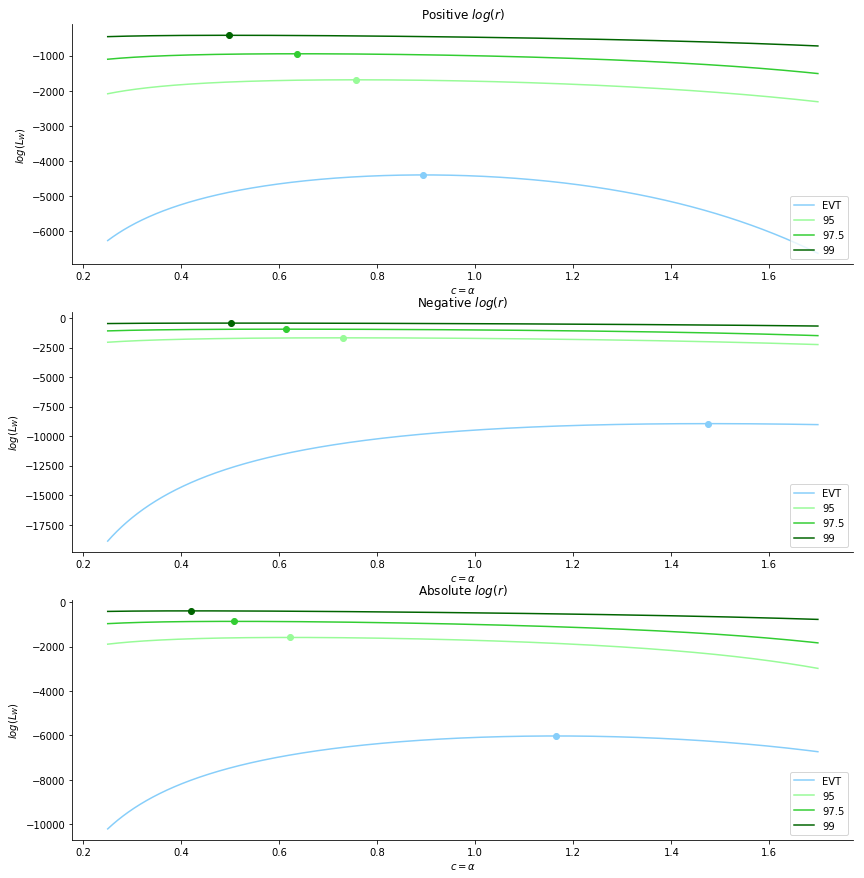

In [100]:
colors_mle = {
    'evt': 'lightskyblue',
    '95': 'palegreen',
    '97.5': 'limegreen',
    '99': 'darkgreen',
}

fig, ax = pl.subplots(nrows=3, ncols=1, figsize=(14, 15))

# positive log-returns
ax[0].plot(c_ok['pos'], log_like_weib['pos']['evt'], color=colors_mle['evt'], label='EVT')
i_max = np.argmax(log_like_weib['pos']['evt'])
ax[0].plot(c_ok['pos'][i_max], log_like_weib['pos']['evt'][i_max], marker='o', color=colors_mle['evt'])

for key in ['95', '97.5', '99']:
    ax[0].plot(c_ok[key], log_like_weib['pos'][key], color=colors_mle[key], label=key)
    i_max = np.argmax(log_like_weib['pos'][key])
    ax[0].plot(c_ok[key][i_max], log_like_weib['pos'][key][i_max], marker='o', color=colors_mle[key])
    
ax[0].set(title=r'Positive $log(r)$')


# negative log-returns
ax[1].plot(c_ok['neg'], log_like_weib['neg']['evt'], color=colors_mle['evt'], label='EVT')
i_max = np.argmax(log_like_weib['neg']['evt'])
ax[1].plot(c_ok['neg'][i_max], log_like_weib['neg']['evt'][i_max], marker='o', color=colors_mle['evt'])

for key in ['95', '97.5', '99']:
    ax[1].plot(c_ok[key], log_like_weib['neg'][key], color=colors_mle[key], label=key)
    i_max = np.argmax(log_like_weib['neg'][key])
    ax[1].plot(c_ok[key][i_max], log_like_weib['neg'][key][i_max], marker='o', color=colors_mle[key])
    
ax[1].set(title=r'Negative $log(r)$')


# absolute log-returns
ax[2].plot(c_ok['abs'], log_like_weib['abs']['evt'], color=colors_mle['evt'], label='EVT')
i_max = np.argmax(log_like_weib['abs']['evt'])
ax[2].plot(c_ok['abs'][i_max], log_like_weib['abs']['evt'][i_max], marker='o', color=colors_mle['evt'])

for key in ['95', '97.5', '99']:
    ax[2].plot(c_ok[key], log_like_weib['abs'][key], color=colors_mle[key], label=key)
    i_max = np.argmax(log_like_weib['abs'][key])
    ax[2].plot(c_ok[key][i_max], log_like_weib['abs'][key][i_max], marker='o', color=colors_mle[key])
    
ax[2].set(title=r'Absolute $log(r)$')

    
for a in ax:
    a.set(xlabel=r'$c = \alpha$', ylabel=r'$log(L_W)$')
    a.legend(loc='lower right')

sns.despine()

Ok, ora che abbiamo le MLE per i tre tipi di returns e i minimi, possiamo fittare la Weibull sui recurrence intervals:

In [ ]:
# class QExponentialRV(scipy.stats.rv_continuous):
#     """
#     The q-exponential distribution centered in 0 with scale 1.
#     """
    
#     def _pdf(self, x):
#         """Probability density function for the q-exponential distribution"""
#         pass
    
#     def _argcheck(self, ...):
#         """Check for the correct support and shape/scale."""
#         pass